# Product Image Recognition

# Transfer Learning CNN

This is transfer learning.

In [1]:
from __future__ import print_function, division

#general operations
import time
import os
import copy
import pathlib

#for openning images via an URL
from PIL import Image
import requests

#data processing
import pandas as pd
import numpy as np

#data visualisation
import matplotlib.pyplot as plt

#ML tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import models, transforms
import torch.nn.functional as F

## Data Cleaning and Structuring

In [2]:
from empdata import *

In [3]:
elecdata = EmpImageData(os.path.join('tabular data', 'elec_final.csv'))

In [4]:
elecdata.create_dataset('LABEL','PRODUCT_ID','data/eg_data');

There are in total 0 missing data.


In [5]:
elecdata.classes_num

37

## Create Dataset Object

In [6]:
#setting up the image transformation
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
datasets_loader, dataset_sizes = elecdata.mktorchdataloaders(transformations=transformations)

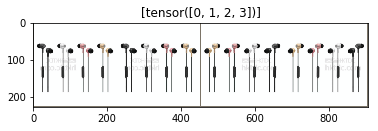

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(datasets_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes])

In [9]:
print(inputs.size())

torch.Size([4, 3, 224, 224])


## Defining Model and Training Procedure

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_record=[]
    val_record=[]
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in datasets_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_record.append([epoch_loss,epoch_acc])
            else:
                val_record.append([epoch_loss,epoch_acc])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_record, val_record

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
torch.cuda.is_available()

True

In [13]:
model_freeze = torchvision.models.resnet50(pretrained=True)
for param in model_freeze.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_freeze.fc.in_features
model_freeze.fc = nn.Linear(num_ftrs, elecdata.classes_num)

model_freeze = model_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_freeze = optim.SGD(model_freeze.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_freeze, step_size=3, gamma=0.1)

In [14]:
print(model_freeze)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
model_freeze, t_record, v_record = train_model(model_freeze, criterion, optimizer_freeze,
                                               exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
train Loss: 2.9277 Acc: 0.2210


val Loss: 2.5675 Acc: 0.2421


Epoch 1/23
----------
train Loss: 2.7416 Acc: 0.2375


val Loss: 2.5533 Acc: 0.2356


Epoch 2/23
----------
train Loss: 2.6618 Acc: 0.2460


val Loss: 2.5635 Acc: 0.2424


Epoch 3/23
----------
train Loss: 2.4379 Acc: 0.2864


val Loss: 2.4893 Acc: 0.2680


Epoch 4/23
----------
train Loss: 2.4301 Acc: 0.2886


val Loss: 2.4635 Acc: 0.2615


Epoch 5/23
----------
train Loss: 2.4270 Acc: 0.2884


val Loss: 2.4604 Acc: 0.2647


Epoch 6/23
----------
train Loss: 2.4280 Acc: 0.2934




In [ ]:
torch.save(model_freeze, 'model_tl_elec_res50.pth')

## Model Evaluation

In [30]:
import matplotlib.pyplot as plt
def plot_graph(t, v, gtype='loss'):
    
    if gtype != 'loss':
        ind = 1
        gtype = 'accuracy'
    else:
        ind = 0
        
    periods=len(t_record)
    x=np.arange(0,periods)
    
    train=[x[ind] for x in t]
    val=[x[ind] for x in v]
    
    plt.plot(x,train)
    plt.plot(x,val)
    
    plt.legend(['train','val'])
    plt.title('{}: Train vs Validation'.format(gtype))
    plt.ylabel(gtype)
    plt.xlabel('Epoch')

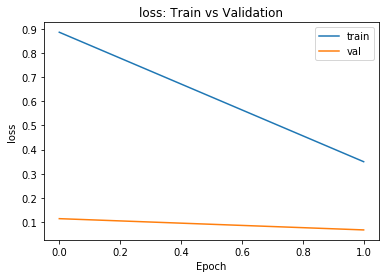

In [52]:
plot_graph(t_record, v_record)

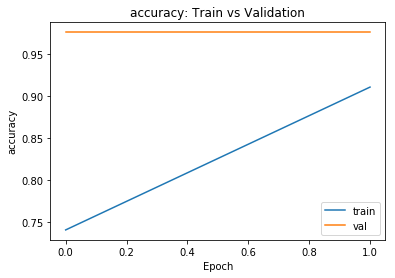

In [53]:
plot_graph(t_record, v_record, gtype='accuracy')

In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(datasets_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [55]:
visualize_model(model_freeze)

NameError: name 'model_ft' is not defined

In [70]:
def visualise_online_model(model):
    num_images=len(test_set)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, inputs in enumerate(testset_loader):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [78]:
test_images_online=[
    'http://images.the-house.com/head-sensor-ski-helmet-blk-16.jpg',
    'http://demandware.edgesuite.net/aakn_prd/on/demandware.static/-/Sites-bdel/default/dw8b3f6b64/products/carabiners_draws/S16/210074_Mini_Pearbiner_Screwgate_Carabiner_web.jpg'
    'http://content.backcountry.com/images/items/900/MAR/MAR008S/TRUBL.jpg'
]

In [72]:
#creating our own customised data
class productData_test(Dataset):
    def __init__(self, urls, transforms=None):
        self.urls = urls
        self.transforms = transforms
        self.data_len = len(self.urls)
    
    def __getitem__(self, index):
        response=requests.get(self.urls[index])
        img=Image.open(BytesIO(response.content)).convert('RGB')
        transformed_img = transformations(img)
        feed_it_in.append(transformed_img) 
        return transformed_img
    
    def __len__(self):
        return self.data_len

In [73]:
test_set = productData_test(urls=test_images_online, transforms=transformations)
testset_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                batch_size=4,
                                                shuffle=False)

In [76]:
try:
    visualise_online_model(model_freeze)
except:
    pass